In [1]:
import pandas as pd
from fbprophet import Prophet
from datetime import datetime
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import numpy as np


#input csv file 

df = pd.read_csv("temp.csv")
df.head()
print(df.tail())

df.columns=["ds","y"]
df.head()

Importing plotly failed. Interactive plots will not work.


         datetime  meantempc
18622  2019-12-27        7.8
18623  2019-12-28        3.5
18624  2019-12-29        5.0
18625  2019-12-30        4.5
18626  2019-12-31       -0.3


,ds,y
0,1969-01-01,-14.8
1,1969-01-02,-12.3
2,1969-01-03,-8.1
3,1969-01-04,-13.7
4,1969-01-05,-10.3


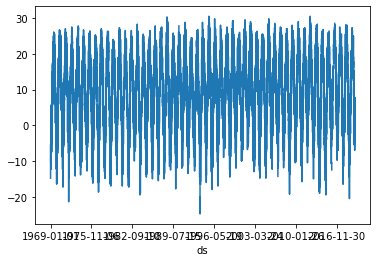

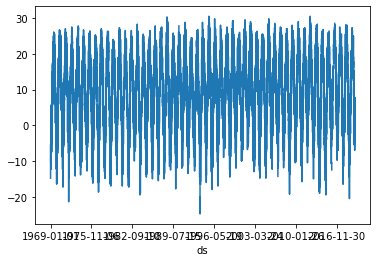

In [104]:
df.set_index('ds').y.plot().figure

In [2]:
#Initializing
m = Prophet()
m.fit(df)

#prediction periods#
future = m.make_future_dataframe(periods=3650*3+8)
future.tail()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
29580,2049-12-27
29581,2049-12-28
29582,2049-12-29
29583,2049-12-30
29584,2049-12-31


In [5]:
##yearly seasonality#
m = Prophet(changepoint_prior_scale=0.1,weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=True)
m.add_seasonality(name='yearly', period=365, fourier_order=20)
forecast = m.fit(df).predict(future)

#prediction periods#
future = m.make_future_dataframe(periods=3650*3+8)
future.tail()

forecast[["ds","yhat","yhat_lower","yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
29580,2049-12-27,-1.769387,-13.410775,8.905897
29581,2049-12-28,-1.922047,-13.303567,9.398945
29582,2049-12-29,-2.070905,-12.821563,9.075812
29583,2049-12-30,-2.215416,-13.488222,9.500041
29584,2049-12-31,-2.355071,-13.947904,8.991317


In [6]:
##evaluate performance by monthly data

yhat = forecast[["ds","yhat"]]
yhat = yhat.set_index("ds")
temp_predict = yhat.resample('M').mean()
temp_predict.to_csv('temp_predict.csv')

df['ds'] = pd.to_datetime(df['ds'])
temp_test = df.set_index("ds").y.resample('M').mean()
temp_test.to_csv("temp_test.csv")

df1 = pd.read_csv("temp_predict.csv")
df2 = pd.read_csv("temp_test.csv")

error= np.mean(np.abs(df2["y"]-df1["yhat"][0:51*12])/df2["y"])
print(error)


0.13842885020616397


In [10]:
#Evaluate performance by yearly data

temp_predict_y = yhat.resample('AS').mean()
temp_predict_y.to_csv('temp_predict1.csv')
temp_test_y = df.set_index("ds").y.resample('AS').mean()
temp_test_y.to_csv("temp_test1.csv")
df3 = pd.read_csv("temp_predict1.csv")
df4 = pd.read_csv("temp_test1.csv")

MAE = np.mean(np.abs(df4["y"]-df3["yhat"][0:50]))
MAPE = np.mean(np.abs(df4["y"]-df3["yhat"][0:50])/df4["y"][0:50])

print(MAPE,MAE)

0.061205013481514234 0.5843832645357613


In [127]:
###evaluate performance


def make_comparison_dataframe(historical, forecast):
    return forecast.set_index("ds")[["yhat"]].join(historical.set_index("ds"))

cmp_df = make_comparison_dataframe(df, yhat)[0:18626]

##define a function to calculate MAPE and MAE
def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df["e"] = df["y"] - df["yhat"]
    df["p"] = 100 * df["e"] / df["y"]
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name:np.mean(np.abs(predicted_part[error_name]))
    
    return {"MAPE":error_mean('p'), "MAE": error_mean('e')}

prediction_size = 365*10  # 10 years prediction
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print (err_name,err_value)

MAPE inf
MAE 3.3048059306247834


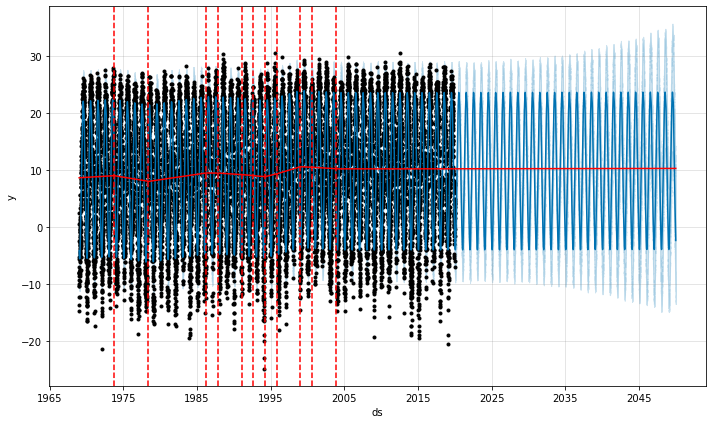

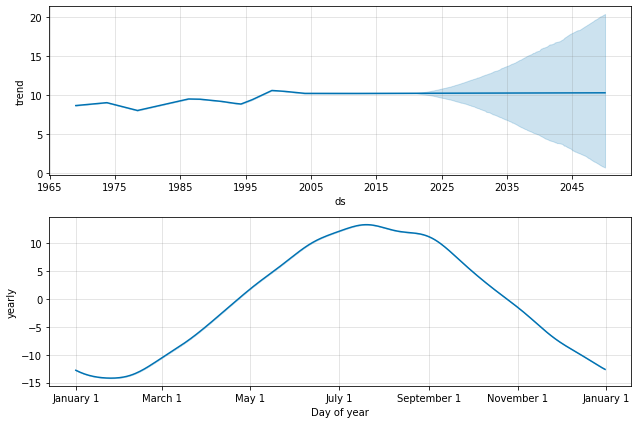

In [168]:
###Figure

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),m,forecast)
plt.xlabel("year")
plt.ylabel("Temperature(C)")
plt.savefig("preci.png")
fig = m.plot_components(forecast)